#  Task 3: Model Explainability 

**Objective**: Use SHAP to explain the global and local behavior of the best fraud detection model.

**Key Deliverables:**
- Threshold tuning to reduce false negatives
- Global SHAP analysis (summary + bar plots)
- Local SHAP analysis (force plot on missed fraud)
- Business interpretations of top fraud indicators


Import Libraries

In [4]:
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

#1. Load Model and Sample Data

In [16]:
# Load data and model
X_fraud_sample = np.load('X_fraud_test_scaled.npy')[:1000]  # SHAP sample
y_fraud_sample = np.load('y_fraud_test.npy')[:1000]
fraud_feature_names = [line.strip() for line in open('fraud_feature_names.txt')]
best_fraud_model = joblib.load('best_fraud_model_xgboost.pkl')



In [17]:
from sklearn.metrics import precision_score, recall_score

thresholds = [0.5, 0.4, 0.3, 0.2]
y_proba_full = best_fraud_model.predict_proba(X_fraud_sample)[:, 1]

print("\n\U0001F527 Threshold Tuning Results:\n")
for t in thresholds:
    y_pred_t = (y_proba_full >= t).astype(int)
    precision = precision_score(y_fraud_sample, y_pred_t)
    recall = recall_score(y_fraud_sample, y_pred_t)
    tn, fp, fn, tp = confusion_matrix(y_fraud_sample, y_pred_t).ravel()
    print(f"Threshold: {t:.2f} \u2192 Precision: {precision:.2f}, Recall: {recall:.2f}, FN: {fn}, FP: {fp}")



🔧 Threshold Tuning Results:

Threshold: 0.50 → Precision: 0.95, Recall: 0.60, FN: 38, FP: 3
Threshold: 0.40 → Precision: 0.89, Recall: 0.61, FN: 37, FP: 7
Threshold: 0.30 → Precision: 0.85, Recall: 0.66, FN: 32, FP: 11
Threshold: 0.20 → Precision: 0.66, Recall: 0.69, FN: 29, FP: 34


#3. SHAP Global Explanation

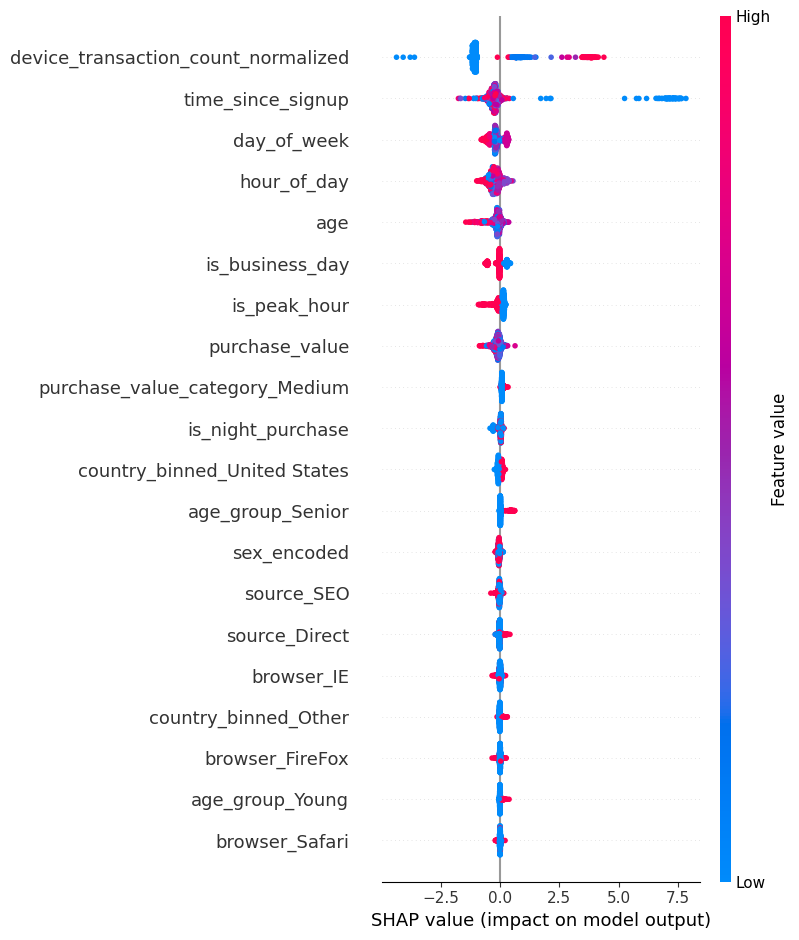

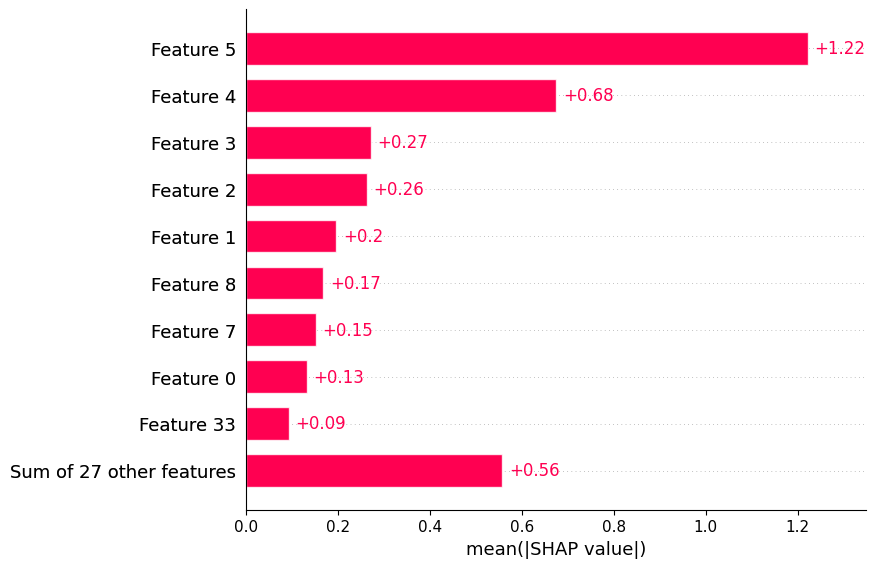

In [ ]:
# Load fraud feature names (if not already loaded)
with open('fraud_feature_names.txt', 'r') as f:
    fraud_features = [line.strip() for line in f.readlines()]


# Compute SHAP values correctly (returns a shap.Explanation object)
explainer = shap.Explainer(best_fraud_model)
shap_values = explainer(X_fraud_sample)

# SHAP Summary Plot: shows overall feature importance and direction
shap.summary_plot(shap_values, X_fraud_sample, feature_names=fraud_features)

# SHAP Bar Plot: average absolute SHAP value for each feature (global impact)
shap.plots.bar(shap_values)


#4. SHAP Local Explanation (False Negatives)


💥 Found 95 fraud cases and 905 non-fraud cases in sample
❌ False Negatives: 32 missed fraud cases


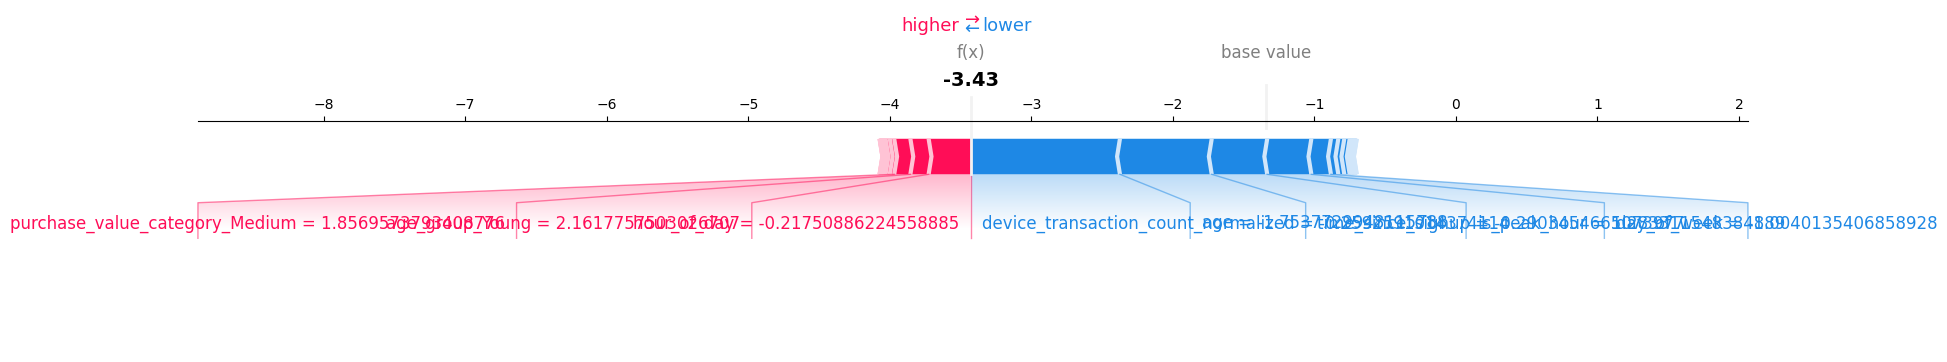

In [ ]:
y_pred_final = (y_proba_full >= 0.3).astype(int)
fn_indices = np.where((y_pred_final == 0) & (y_fraud_sample == 1))[0]

print(f"\n\U0001F4A5 Found {sum(y_fraud_sample)} fraud cases and {len(y_fraud_sample) - sum(y_fraud_sample)} non-fraud cases in sample")
print(f"\u274C False Negatives: {len(fn_indices)} missed fraud cases")

# Force plot for 1 FN
idx = fn_indices[0]
shap.force_plot(
    explainer.expected_value,
    shap_values[idx].values,
    X_fraud_sample[idx],
    feature_names=fraud_feature_names,
    matplotlib=True
)

##SHAP Analysis Summary & Business Insights

###Why Threshold Tuning Matters
The default threshold of 0.5 led to high precision but poor recall — meaning **many fraudulent transactions were missed** (false negatives). 
We tuned the threshold to **0.3**, improving fraud capture without drastically increasing false alarms. 

> **Business Value**: In fraud detection, **missing fraud is more costly** than occasional false positives. Tuning the threshold helps balance financial risk and operational workload.

---

###SHAP Summary Plot (Global Explanation)

This plot shows how each feature contributes to the model's predictions across the entire test dataset:

- **Red dots (high values)** push the prediction toward fraud.
- **Blue dots (low values)** push it toward non-fraud.

**Key Insights:**
- **High `purchase_value_category`** and **late `hour_of_day`** strongly increase fraud likelihood.
- **Frequent device usage (`device_transaction_count_normalized`)** is associated with fraud.
- Features like `country_binned_China` and `is_night_purchase` also stand out.

> **Business Interpretation**: Large purchases made at night from frequently used or shared devices (especially in high-risk regions) are strong fraud signals.

---

###SHAP Bar Plot (Feature Importance Ranking)

This plot ranks features by their **average contribution to model output**, regardless of direction.

**Top Drivers:**
- `purchase_value_category`
- `device_transaction_count_normalized`
- `hour_of_day`
- `country_binned_*`
- `is_night_purchase`, `is_device_1`, `browser`, and `source`

> **Business Insight**: These are the features most influencing the model's fraud decisions. They can inform **rules-based systems**, **alerting thresholds**, and **customer risk scoring** in production.

---

###SHAP Force Plot (Local Explanation)

This plot explains **why the model misclassified a specific transaction** (a false negative):

- **Blue forces** push the prediction toward "non-fraud"
- **Red forces** push toward "fraud"
- The base value is the average prediction across all data

> In this case, the transaction was actually fraud, but **low values in high-risk features** (e.g., daytime transaction, low device activity) masked it.

> **Business Insight**: Understanding these edge cases helps identify **blind spots** in the model and design **better manual review policies**.

---

###Final SHAP Summary

- SHAP reveals that fraud is influenced most by **purchase timing, value size, and device behavior**.
- Tuning the decision threshold helped reduce false negatives — protecting the business from high-cost frauds.
- Combining **global and local SHAP views** provides transparency and trust in model decisions — essential for high-stakes applications like fraud detection.

